Compare time- and spatially averaged NextSim model output to CS2SMOS before the ice break-up occurs (i.e. start-Feb 2013)

In [2]:
# allow plots to be interactive in the notebook
%matplotlib notebook

import numpy as np
import datetime as dt
import pynextsim.openers as pnops
import mod_netcdf_utils as mnu
import pynextsim.gridding as png
from pynextsim.netcdf_list import NetcdfList
from pynextsim.irregular_grid_interpolator import IrregularGridInterpolator
import matplotlib.pyplot as plt
from pynextsim.nextsim_bin import NextsimBin as nb

import os 
import sys

import matplotlib.colors as colors

In [3]:
outpath = 'data/'
outpath_plots = 'plots/'

# specify model output directory
fl = '/cluster/work/users/rheinlender/breakup2013/outputs/20121115'

# create time array for fetching data
start_date=dt.datetime(2013,1,1,1,30)
deltat=3    # 3-hour output frequency
tintv = int(24/deltat)    # time interval 24 hours, end date 2013-02-02 

date_list = [start_date + dt.timedelta(hours=3*x) for x in range(0, tintv)]
print(date_list)    

dto = dt.datetime(2013,2,1)



[datetime.datetime(2013, 1, 1, 1, 30), datetime.datetime(2013, 1, 1, 4, 30), datetime.datetime(2013, 1, 1, 7, 30), datetime.datetime(2013, 1, 1, 10, 30), datetime.datetime(2013, 1, 1, 13, 30), datetime.datetime(2013, 1, 1, 16, 30), datetime.datetime(2013, 1, 1, 19, 30), datetime.datetime(2013, 1, 1, 22, 30)]


In [4]:
# open Morrings from Nextsim output

opener_moorings = pnops.OpenerNextsimMoorings(fl)
#moorings = NetcdfList(['/cluster/work/users/rheinlender/breakup2013/outputs/20121115/Moorings_2013m02.nc'])
moorings = NetcdfList(['/cluster/work/users/rheinlender/breakup2013/outputs/breakup2013.ERA5.r10/Moorings_2013m01.nc'])

# prepare input 
nx,ny = moorings.get_var(start_date, 'Thickness').shape
nt = len(date_list)
print(nt,nx,ny)

nsit = np.zeros((nt,nx,ny))
nsic = np.zeros((nt,nx,ny))

# get thickness for speficied dates
for n in range(len(date_list)):
    nsit[n, :,:] = moorings.get_var(date_list[n], 'Thickness') # get nextsim ice thickness
    nsic[n,:,:] =  moorings.get_var(date_list[n], 'Concentration') 

8 782 651


In [5]:
# calculate daily average thickness

nsit_ave = nsit.mean(axis=0) # average along time dimension
nsic_ave = nsic.mean(axis=0) # average along time dimension


<IPython.core.display.Javascript object>


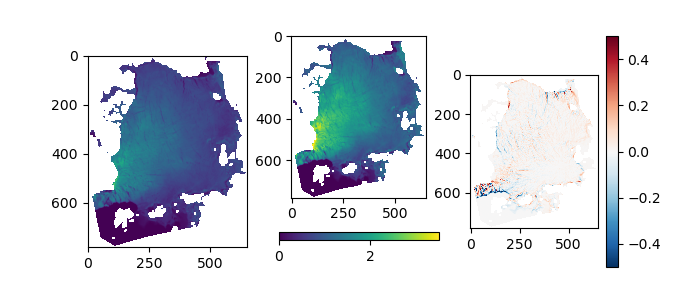

In [34]:
# Compare thickness at start_date and end_date to make sure they are not equal 
fig, ax = plt.subplots(ncols=3,figsize=(7,3))

ax[0].imshow(nsit[0,:,:])
im1=ax[1].imshow(nsit[-1,:,:], vmax=3.5)
obj=ax[2].imshow(nsit[-1,:,:]-nsit[0,:,:], vmin=-.5, vmax=.5, cmap='RdBu_r')
fig.colorbar(obj)
fig.colorbar(im1, ax=ax[1],  orientation="horizontal")

In [7]:
# get ice thickness from cs2smos on neXtSIM mesh elements



obs_inpath = '/cluster/projects/nn2993k/sim/data/CS2_SMOS_v2.0/'
#obs_file = obs_inpath + 'awi-cs2smos-l4-sithick-cryosat2_smos_merged-rep-nh25km_ease2-20130128_20130203-fv2p0.nc'
obs_file = obs_inpath + 'awi-cs2smos-l4-sithick-cryosat2_smos_merged-rep-nh25km_ease2-20121231_20130106-fv2p0.nc'

o = pnops.OpenerCs2SmosThick()

bbox = moorings.file_objects[0].get_bbox(o.projection.pyproj)

# Fix - variable names to be consistent with nc file  
o.variables['Thickness'].name = 'analysis_ice_thickness'
o.variables['Thickness_Uncertainty'].name = 'analysis_thickness_unc'
o.variables['Concentration'].name = 'ice_conc'

nci_obs = mnu.nc_getinfo(obs_file)
obs_grid = png.Grid.init_from_nc_getinfo(nci_obs, projection=o.projection, bbox=bbox)    #cs2smos grid
obs_vars = obs_grid.get_external_data(
                o.variables,
                start_date,
                nci=nci_obs,
                data_on_same_grid=True, #we always use the obs grid
                allow_missing=True)
osit = obs_vars['Thickness']
osit.shape


reduce grid bbox:  [-2584859.0247218814, 2714189.166638696, -2151842.919231681, 3139273.504268901]
Reading external data (on same grid) ............
Variable:  analysis_ice_thickness
Variable:  analysis_thickness_unc
Variable:  ice_conc


(212, 212)

<IPython.core.display.Javascript object>


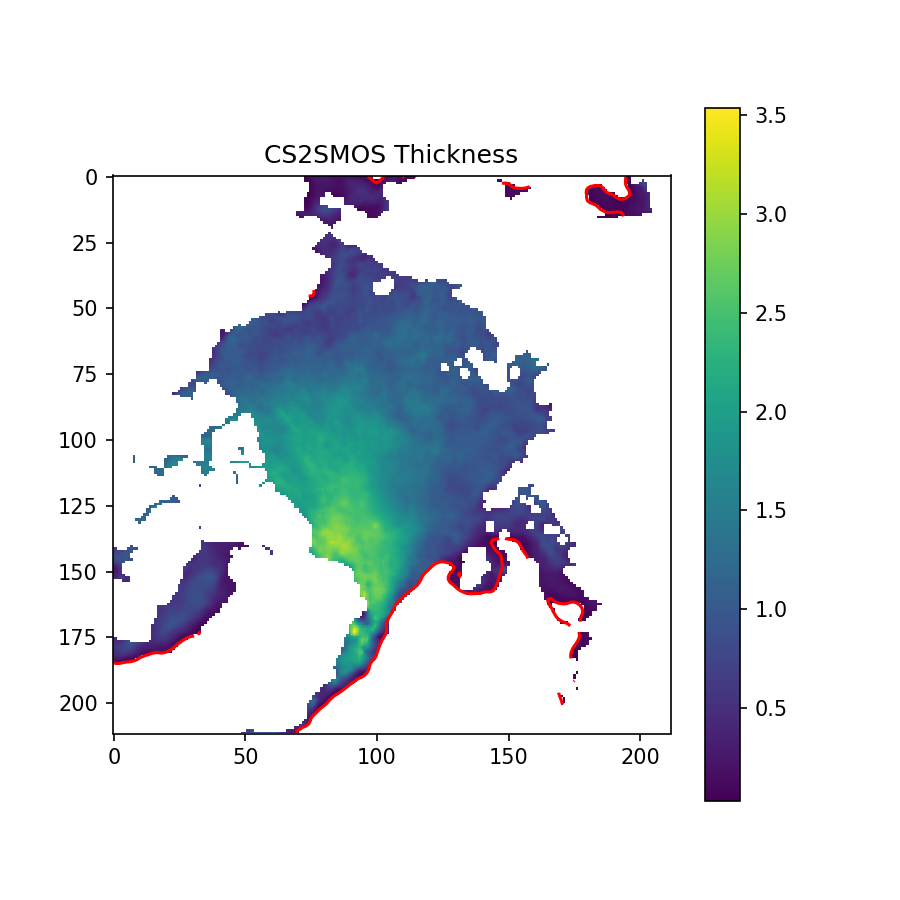

Text(0.5, 1.0, 'CS2SMOS Thickness')

In [28]:
# plot observed ice thickness on native grid
fig = plt.figure(dpi=150, figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
c=ax.imshow(osit)

cont=ax.contour(obs_vars['Concentration'], levels=[0.3], colors='r')
fig.colorbar(c, ax=ax)
ax.set_title('CS2SMOS Thickness')


In [9]:
# interpolate model grid to observational grid (NB: slow)

lon, lat = moorings.file_objects[0].get_lonlat() 
xy_mod = obs_grid.projection.pyproj(lon, lat)    #model grid
irreg_grid_interp = IrregularGridInterpolator(*xy_mod, *obs_grid.xy)
print('done')

done


In [10]:
# get model data on observational grid

nsiti = irreg_grid_interp.interp_field(nsit_ave)
nsici = irreg_grid_interp.interp_field(nsic_ave)


<IPython.core.display.Javascript object>


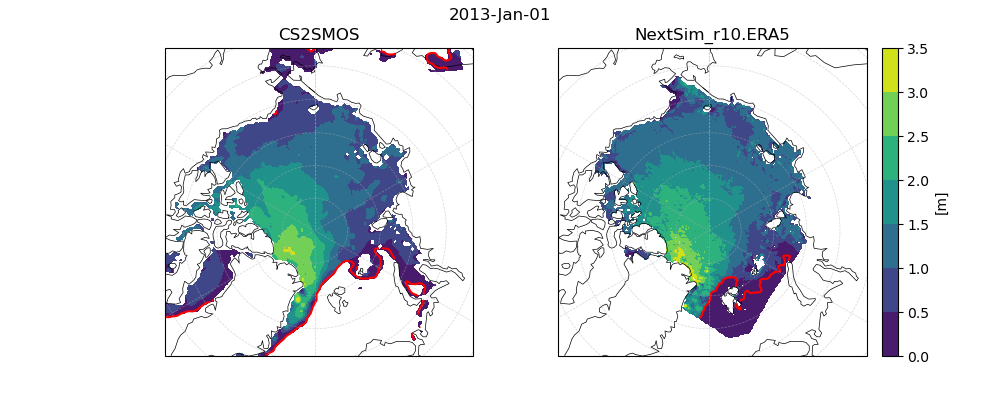

In [36]:
# Plot Mooring (or other nc data) using cartopy

from cartopy import config
import cartopy.crs as ccrs
import pyproj

plt.close('all')

# get x and y coordinates from observation grid
x=obs_grid.xy[0]
y=obs_grid.xy[1]

# get projection info from model
mproj = pyproj.Proj(moorings.file_objects[0].proj_info.proj4_string)

# get bounding box from model (i.e. small_arctic_10km)
img_extent = moorings.file_objects[0].get_bbox(mproj)

img_extent = bbox    #get from bbox

# make discrete colormap
levels = np.arange(0., 4., .5)
bounds=np.linspace(0,4,9)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

fig = plt.figure(figsize=(10,4))

# observation
ax1 = plt.subplot(1, 2, 1, projection=ccrs.NorthPolarStereo(central_longitude=0))
plt.title('CS2SMOS')

ax1.coastlines(resolution='110m', linewidth=0.5)
ax1.gridlines(linewidth=0.5, alpha=0.5, linestyle='--')
ax1.set_extent(img_extent, crs=ccrs.NorthPolarStereo())

cs1=ax1.contourf(osit, origin='upper', extent=img_extent, levels=levels,
               transform=ccrs.NorthPolarStereo())

line_c=ax1.contour(x, y, obs_vars['Concentration'],colors=['red'], levels=[0.3], 
               transform=ccrs.NorthPolarStereo())
# model
ax2 = plt.subplot(1, 2, 2, projection=ccrs.NorthPolarStereo(central_longitude=0))
plt.title('NextSim_r10.ERA5')

ax2.coastlines(resolution='110m', linewidth=0.5)
ax2.gridlines(linewidth=0.5, alpha=0.5, linestyle='--')
ax2.set_extent(img_extent, crs=ccrs.NorthPolarStereo())

cs2=ax2.contourf(nsiti, origin='upper', extent=img_extent, levels=levels, 
               transform=ccrs.NorthPolarStereo())

line_c2=ax2.contour(x, y, nsici,colors=['red'], levels=[0.3], 
               transform=ccrs.NorthPolarStereo())

fig.suptitle(start_date.strftime('%Y-%b-%d'))
plt.colorbar(cs2, ax=ax2, fraction=0.046, pad=0.04, label='[m]')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

fig.savefig(outpath_plots+'sit_'+ start_date.strftime('%Y-%b-%d') + '_cs2smos_nextsim.r10.era5.png',
            bbox_inches='tight')

In [17]:
levels = np.arange(0., 4., .5)

levels

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5])

In [ ]:
# Plot Mooring (or other nc data) using cartopy
# using pcolormesh

from cartopy import config
import cartopy.crs as ccrs
import pyproj

plt.close('all')


# get projection info from model
mproj = pyproj.Proj(moorings.file_objects[0].proj_info.proj4_string)

# get bounding box from model (i.e. small_arctic_10km)
bbox = moorings.file_objects[0].get_bbox(mproj)

# define mesh
dx = obs_grid.dx
dy = obs_grid.dy

x = np.arange(np.min(obs_grid.xy[0]), np.max(obs_grid.xy[0]), +dx)
y = np.arange(np.max(obs_grid.xy[1]), np.min(obs_grid.xy[1]), -dy)

x.shape, y.shape, nsiti.shape

# plot the underlying map projection
fig = plt.figure(figsize=(4, 4))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
plt.title('some title\n'
          'timestr')

cs = ax.coastlines(resolution='110m', linewidth=0.5)

ax.gridlines(linewidth=0.5, alpha=0.5, linestyle='--')
ax.set_extent([-180, 180, 68, 90], crs=ccrs.PlateCarree())

# add the image. "origin" is set to the upper left corner
cs=ax.pcolormesh(x,y,nsiti, transform=ccrs.NorthPolarStereo(),  vmin=0, vmax=4)
fig.colorbar(cs, ax=ax)

In [ ]:
start_date.strftime('%Y-%b-%d')

